# Finetuning BERT for Sentiment Analysis: Airline reviews

Note this code is meant for pedagogical purposes only. The goal is to illustrate each aspect of BERT-based finetuning so the implementation is *extremely* verbose. These days, one can finetune BERT on a downstream task using just a few lines of code, as in [this example](https://huggingface.co/learn/nlp-course/en/chapter3/3?fw=pt).

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocessing the airline tweets

In [ ]:
# Download data
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)
# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

The training data has 2 files, each containing 1700 complaining/non-complaining tweets. Each tweet in the data contains at a hashtag of an airline.

First, let's load the training data and add labels based on the csv from which the tweet was extracted. Because we use only the text data to classify, we will drop unimportant columns and only keep id, tweet and label columns.


In [ ]:
import pandas as pd

 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1
# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)
# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)
# Display 5 random samples
data.sample(5)

,id,tweet,label
1686,162642,@SouthwestAir fucking sucks ass.,0
2920,121200,@alliemoss @SouthwestAir glad to hear! And gl...,1
2946,123962,@DeltaAssist what number do I call to Cancel m...,1
646,35066,@AmericanAir screws a broke college kid ( @Jus...,0
1581,45640,@AmericanAir lost my moms luggage was supposed...,0


In [ ]:
from sklearn.model_selection import train_test_split
X = data.tweet.values
y = data.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')
# Keep important columns
test_data = test_data[['id', 'tweet']]
# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
2729,104543,"When one flies first class, one expects to be ..."
2336,89646,"@AmericanAir, I'm disappointed my global entry..."
2374,90893,@united keep on #sucking #worst#airline
1715,66352,"@AmericanAir has officially LOST my bag, maybe..."
1089,42851,@MatthewLush @tazz_bear @JetBlue that sucks


In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


### Download BERT from HF and set up the tokenizer

Our pretrained BERT will be automatically downloaded from HF by specifying the model in the class args.

As we'll learn in class 7, we must use the tokenizer provided by the library since (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the “attention mask”.

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [ ]:
from transformers import BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    # For every sentence...
    for sent in data:
        # encode_plus will:
        #    (1) Tokenize the sentence
        #    (2) Add the [CLS] and [SEP] token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add [CLS] and [SEP]
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Before tokenizing, we need to specify the maximum length of our sentences.

In [ ]:
import numpy as np
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [ ]:
# Specify MAX_LEN
MAX_LEN = 64
# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)
# Run function preprocessing_for_bert on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [101, 1057, 2063, 1012, 6300, 28774, 10259, 1045, 2128, 8654, 2098, 2005, 2484, 3178, 2044, 1045, 11333, 2039, 6873, 3968, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Create PyTorch DataLoader

We will create an iterator for our dataset using the torch `DataLoader` class. This will save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) of the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The transformers library has the `BertForSequenceClassification` class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a `BertClassifier` class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set False to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token [CLS] for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        return logits

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 68.2 µs


### Optimizer & Learning Rate Scheduler

To fine-tune `BertClassifier`, we need to create an optimizer. The original BERT paper recommends the following hyper-parameters for finetuning:

* Batch size: 16 or 32
* Learning rate (Adam): 5e-5, 3e-5 or 2e-5
* Number of epochs: 2, 3, 4

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)
    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### Training Loop

We will train `BertClassifier` for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set.

#### Training

* Unpack our data from the dataloader and load the data onto the GPU
* Zero out gradients calculated in the previous pass
* Perform a forward pass to compute logits and loss
* Perform a backward pass to compute gradients (loss.backward())
* Clip the norm of the gradients to 1.0 to prevent “exploding gradients”
* Update the model’s parameters (optimizer.step())
* Update the learning rate (scheduler.step())

#### Evaluation:

* Unpack our data and load onto the GPU
* Forward pass
* Compute loss and accuracy rate over the validation set
* The script below is commented with the details of our training and evaluation loop.

In [ ]:
import random
import time
# Specify loss function
loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # Put the model into the training mode
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # Zero out any previously calculated gradients
            model.zero_grad()
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            # Perform a backward pass to calculate gradients
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("n")
    print("Training complete!")
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    val_accuracy = []
    val_loss = []
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...n
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.688283   |     -      |     -     |   6.82   
   1    |   40    |   0.654888   |     -      |     -     |   6.08   
   1    |   60    |   0.597227   |     -      |     -     |   6.14   
   1    |   80    |   0.581335   |     -      |     -     |   6.20   
   1    |   95    |   0.531221   |     -      |     -     |   4.58   
----------------------------------------------------------------------
   1    |    -    |   0.615534   |  0.524613  |   76.99   |   30.96  
----------------------------------------------------------------------
n
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.436600   |     -      |     -     |   6.61   
   2    |   40    |   0.372341   |     -      |     -     |   6.3

### Evaluation on Validation Set
The prediction step is similar to the evaluation step that we performed in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.


In [ ]:
import torch.nn.functional as F
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []
    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8529
Accuracy: 77.65%


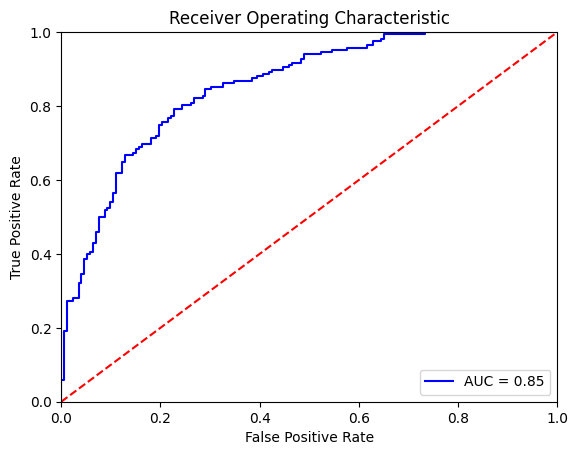

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)